In [71]:
import numpy as np
import sys
sys.path.append('../../')
import do_mpc
from casadi import *
import matplotlib.pyplot as plt
N_ref = 300
J = 380
La = 1.3
Lb = 1.3
m = 500
Cy = 0.01
t_s = 0.1 #sample time
N = 50
eqn = "0.15 * np.sin(0.75 * x)"
eqn2 = "1 - x"
#y_ref if 0.15*np.sin(h*x_ref) then n<0.5 is excellent
#y_ref if 0.15*np.sin(h*x_ref) then 0.5<n<1 (h1 = 1) is fairly manageable
#y_ref if 0.15*np.sin(h*x_ref) then 1<n<1.5 (h2 = 1.5) is regrettably manageable
#y_ref if 0.15*np.sin(h*x_ref) then n>1.5 definitely avoidable


In [72]:
def y_x(x):
    return eval(eqn)

def v_x(x):
    return eval(eqn2)

In [73]:
def mpc_model():
    # Obtain an instance of the do-mpc model class
    # and select time discretization:
    model_type = 'continuous' # either 'discrete' or 'continuous'
    model = do_mpc.model.Model(model_type)

    # Introduce new states, inputs and other variables to the model, e.g.:
    xc=model.set_variable(var_type='_x',var_name='xc',shape=(1,1))
    yc=model.set_variable(var_type='_x',var_name='yc',shape=(1,1))
    v=model.set_variable(var_type='_x',var_name='v',shape=(1,1))
    theta=model.set_variable(var_type='_x',var_name='theta',shape=(1,1))
    phi=model.set_variable(var_type='_x',var_name='phi',shape=(1,1))
    delta=model.set_variable(var_type='_x',var_name='delta',shape=(1,1))
#     a_s=model.set_variable(var_type='_x',var_name='a_s',shape=(1,1))
#     w_s=model.set_variable(var_type='_x',var_name='w_s',shape=(1,1))
    
    # virtual state for timing law
    z = model.set_variable(var_type='_x', var_name='z', shape = (1,1))
    
    
#     #time varying setpoint for path following
#     target_x = model.set_variable(var_type = '_tvp', var_name = 'target_x', shape = (1,1))
#     target_y = model.set_variable(var_type = '_tvp', var_name = 'target_y', shape = (1,1))
    

    #control inputs
    a=model.set_variable(var_type='_u',var_name='a',shape=(1,1))
    w=model.set_variable(var_type='_u',var_name='w',shape=(1,1))
    
    # virtual control input for timing law
    u_v = model.set_variable(var_type='_u',var_name='u_v', shape=(1,1))
    
    # Force on tyres
    Fyf=Cy*(delta-(La*phi)/v)
    Fyr=(Cy*Lb*phi)/v
    
    
    # vehicle dyanmics equations
    equations=vertcat(v*np.cos(theta), 
                      v*np.sin(theta),
                      a* np.cos(delta)-(2.0/m)*Fyf*np.sin(delta),
                      phi,
                      (1.0/J)*(La*(m*a*np.sin(delta)+2*Fyf*np.cos(delta))-2*Lb*Fyr),
                      w,
        #               (1/t_s)*(a-a_s),
        #               (1/t_s)*(w-w_s)
                     )
    
    #RHS of vehicle dynamics ODEs
    model.set_rhs('xc',equations[0])
    model.set_rhs('yc',equations[1])
    model.set_rhs('v',equations[2])
    model.set_rhs('theta',equations[3])
    model.set_rhs('phi',equations[4])
    model.set_rhs('delta',equations[5])
#     model.set_rhs('a_s',equations[6])
#     model.set_rhs('w_s',equations[7])
    
    #timing law equation
    timing_law = u_v
    
    #RHS of timing law ODEs
    model.set_rhs('z', timing_law)
#     model.set_rhs('z[1]', timing_law[1])
#     model.set_rhs('z[2]', timing_law[2])
#     model.set_rhs('z[3]', timing_law[3])
#     model.set_rhs('z[4]', timing_law[4])
    
    # Setup model:
    model.setup()

    return model

In [74]:
def controller(model, x_ref,y_ref):
    # Obtain an instance of the do-mpc MPC class
    # and initiate it with the model:
    mpc = do_mpc.controller.MPC(model)

    # Set parameters:
    setup_mpc = {
        'n_horizon': N,
        't_step': t_s,
        'n_robust': 0,
        'open_loop':0,
        'state_discretization': 'collocation',
        'collocation_type': 'radau',
        'collocation_deg': 2,
        'collocation_ni': 2,
        'store_full_solution': True,
    }
    mpc.set_param(**setup_mpc)
    
#     #Configuring the time varying behaviour of the setpoints
    
#     tvp_temp = mpc.get_tvp_template()
#     def tvp_fun(t_now):
#         for k in range(N+1):
#                 tvp_temp['_tvp',k,'target_x'] = x_ref[int(t_now//t_s) + k]
#                 tvp_temp['_tvp',k,'target_y'] = y_ref[int(t_now//t_s) + k]
#         return tvp_temp    
#     mpc.set_tvp_fun(tvp_fun)
    
    
    xc = model.x['xc']
    yc = model.x['yc']
    z = model.x['z']
    
    # Configure objective function:
    # cost = ((model.x['xc'] - model.tvp['target_x'])/(model.tvp['target_x']+1e-9))**2 + ((model.x['yc'] - model.tvp['target_y'])/(model.tvp['target_y']+1e8) )**2
    cost = (xc-z)**2 + (yc-y_x(z))**2 + (model.x['v']-v_x(z))**2
    
    mterm = cost # terminal cost
    lterm = cost # stage cost

    mpc.set_objective(mterm=mterm, lterm=lterm)
    mpc.set_rterm(a=0.000001)
    mpc.set_rterm(w=0.000001) # Scaling for quad. cost.

    # State and input bounds:
#     mpc.bounds['lower','_x','xc']=x_0[0]-1e-4
#     mpc.bounds['lower','_x','yc']=y_lower
    mpc.bounds['lower','_x','v'] = 0 #max reverse speed in m/s
    mpc.bounds['lower','_x','theta'] = -50
    mpc.bounds['lower','_x','phi'] = -50
    mpc.bounds['lower','_x','delta'] = -np.pi/6
    mpc.bounds['lower', '_x', 'z'] = 0
#     mpc.bounds['upper','_x','xc'] = target_x+0.1
#     mpc.bounds['upper','_x','yc'] = y_upper
    mpc.bounds['upper','_x','v'] = 1 #max forward speed in m/s
    mpc.bounds['upper','_x','theta'] = 50
    mpc.bounds['upper','_x','phi'] = 50
    mpc.bounds['upper','_x','delta'] = np.pi/6
    mpc.bounds['lower','_u','a'] = -10
    mpc.bounds['lower','_u','w'] = -10
    mpc.bounds['upper','_u','a'] = 10
    mpc.bounds['upper','_u','w'] = 10
    mpc.bounds['lower','_u', 'u_v'] = 0
#     mpc.bounds['lower','_x','a_s']=-10
#     mpc.bounds['lower','_x','w_s']=-10
#     mpc.bounds['upper','_x','a_s']=10
#     mpc.bounds['upper','_x','w_s']=10

    mpc.setup()

    return mpc

In [75]:
def mpc_simulator(model,x_ref,y_ref):
    # Obtain an instance of the do-mpc simulator class
    # and initiate it with the model:
    simulator = do_mpc.simulator.Simulator(model)

    # Set parameter(s):
    simulator.set_param(t_step = t_s)

    # Set function for time-varying parameters.
    # Get the template
#     tvp_temp = simulator.get_tvp_template()

#     # Define the function (indexing is much simpler ...)
#     def tvp_fun(t_now):
#             tvp_temp['target_x'] = x_ref[int(t_now//t_s)]
#             tvp_temp['target_y'] = y_ref[int(t_now//t_s)]
#             return tvp_temp

#     # Set the tvp_fun:
#     simulator.set_tvp_fun(tvp_fun)

    # Setup simulator:
    simulator.setup()

    return simulator

In [76]:
model = mpc_model()
x_ref = np.linspace(0,30,N_ref)
y_ref = y_x(x_ref)
mpc = controller(model,x_ref,y_ref)
simulator = mpc_simulator(model,x_ref,y_ref)
estimator = do_mpc.estimator.StateFeedback(model)

# x0=np.array([[0],[0],[0.001],[(np.pi/4)*(0.03)],[0],[0],[0],[0]])
simulator.x0['xc'] = 0
simulator.x0['yc'] = 0
simulator.x0['v'] = 1
simulator.x0['theta'] = 0.15*0.75
simulator.x0['phi'] = 0
simulator.x0['delta'] = 0
# simulator.x0['a_s'] = 0
# simulator.x0['w_s'] = 0

simulator.x0['z'] = vertcat(0)

x0 = simulator.x0.cat.full()
mpc.u0['a'] = 0
mpc.u0['w'] = 0
mpc.u0['u_v'] = 1

mpc.x0 = x0
estimator.x0 = x0

mpc.set_initial_guess()

state = []
x = []
y = []
v = []
for k in range(N_ref):
    print('\n\n################################################    ' + str(k) + '    #########################################\n\n')
    state.append(x0)
    x.append(x0[0])
    y.append(x0[1])
    v.append(x0[2])
    u0 = mpc.make_step(x0)
    y_next = simulator.make_step(u0)
    x0 = estimator.make_step(y_next)



################################################    0    #########################################


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     8907
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     2155

Total number of variables............................:     2649
                     variables with only lower bounds:      394
                variables with lower and upper bounds:     1476
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2457
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bo

(0.0, 2.0)

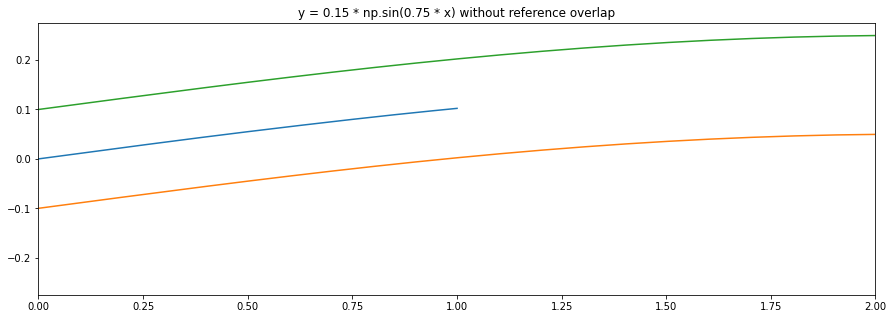

In [80]:
f = plt.figure(figsize=(15,5))
plt.plot(x,y)
plt.plot(x_ref,y_ref-1e-1)
plt.plot(x_ref,y_ref+1e-1)
plt.title("y = " + eqn + " without reference overlap")
plt.xlim([0, 2])

(0.0, 30.0)

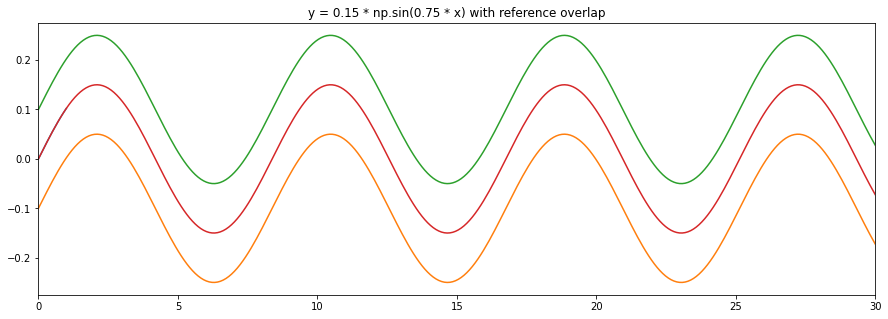

In [78]:
f = plt.figure(figsize=(15,5))
plt.plot(x,y)

plt.plot(x_ref,y_ref-1e-1)
plt.plot(x_ref,y_ref+1e-1)
plt.plot(x_ref,y_ref)
plt.title("y = " + eqn + " with reference overlap")
plt.xlim([0, 30])

simulator.x0['xc'] = 0      
simulator.x0['yc'] = 0                  
simulator.x0['v'] = 0.001                       
simulator.x0['theta'] = (np.pi/4)*(0.03)                       
simulator.x0['phi'] = 0                     
simulator.x0['delta'] = 0               
simulator.x0['a_s'] = 0                     
simulator.x0['w_s'] = 0                 


(0.0, 0.0001)

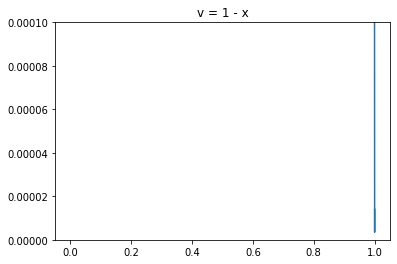

In [97]:
plt.plot(x, v)
plt.title("v = " + eqn2)
# plt.plot(x_ref, v_x(x_ref))
# plt.xlim([29, 30])
plt.ylim([0, 0.0001])

(0.0, 0.0001)

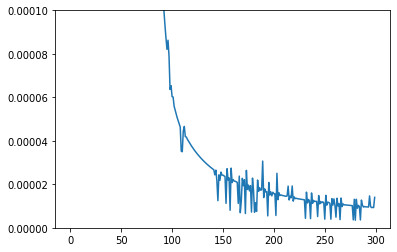

In [102]:
plt.plot(v)
plt.ylim([0, 1e-4])